# Machine Learning Nanodegree
## Capstone Project : Iris Recognition Using CNN
### Ahmed Sedik Al-Ads

In this project we will implement the proposal that had been reviewed. This project evaluates the accuracy for both of benchmark and our proposed CNN models. 



## Step 1: Import Datasets

**In the code cell below, we import a dataset of iris images.  We populate a few variables through the use of the `load_files` function from the scikit-learn library:**

- `train_files`, `valid_files`, `test_files` - numpy arrays containing file paths to images
- `train_targets`, `valid_targets`, `test_targets` - numpy arrays containing onehot-encoded classification labels 
- `cat_names` - list of string-valued person's folder names for translating labels

In [1]:
from sklearn.datasets import load_files       
from keras.utils import np_utils
import numpy as np
from glob import glob

# define function to load train, test, and validation datasets
def load_dataset(path):
    data = load_files(path)
    iris_files = np.array(data['filenames'])
    iris_targets = np_utils.to_categorical(np.array(data['target']), 26)
    return iris_files, iris_targets

# load train, test, and validation datasets
train_files, train_targets = load_dataset('casia/train')
valid_files, valid_targets = load_dataset('casia/test')

test_files, test_targets = load_dataset('casia/test')

# load list of dog names
cat_names = [item[20:-1] for item in sorted(glob("casia/train/*/"))]

# print statistics about the dataset
print('There are %d total Iris categories.' % len(cat_names))
print('There are %s total Iris images.\n' % len(np.hstack([train_files, test_files])))
print('There are %d training Iris images.' % len(train_files))

print('There are %d test Iris images.'% len(test_files))

Using TensorFlow backend.


There are 26 total Iris categories.
There are 1300 total Iris images.

There are 1040 training Iris images.
There are 260 test Iris images.


## Step 2: Pre-processing


**When using TensorFlow as backend, Keras CNNs require a 4D array (which we'll also refer to as a 4D tensor) as input, with shape**

$$
(\text{nb_samples}, \text{rows}, \text{columns}, \text{channels}),
$$

where `nb_samples` corresponds to the total number of images (or samples), and `rows`, `columns`, and `channels` correspond to the number of rows, columns, and channels for each image, respectively.  

The `path_to_tensor` function below takes a string-valued file path to a color image as input and returns a 4D tensor suitable for supplying to a Keras CNN.  The function first loads the image and resizes it to a square image that is $224 \times 224$ pixels.  Next, the image is converted to an array, which is then resized to a 4D tensor.  In this case, since we are working with color images, each image has three channels.  Likewise, since we are processing a single image (or sample), the returned tensor will always have shape

$$
(1, 224, 224, 3).
$$

The `paths_to_tensor` function takes a numpy array of string-valued image paths as input and returns a 4D tensor with shape 

$$
(\text{nb_samples}, 224, 224, 3).
$$

Here, `nb_samples` is the number of samples, or number of images, in the supplied array of image paths.  It is best to think of `nb_samples` as the number of 3D tensors (where each 3D tensor corresponds to a different image) in your dataset!

In [2]:
from keras.preprocessing import image                  
from tqdm import tqdm


def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

### Pre-process the Data

We rescale the images by dividing every pixel in every image by 255.

In [3]:
from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True                 

# pre-process the data for Keras
train_tensors = paths_to_tensor(train_files).astype('float32')/255
valid_tensors = paths_to_tensor(valid_files).astype('float32')/255

test_tensors = paths_to_tensor(test_files).astype('float32')/255

100%|███████████████████████████████████████████████████████████████████████████████| 260/260 [00:00<00:00, 263.46it/s]


## Step 3: Benchmark Model

This CNN consists of one CNV layer with 32 filters followed by one max pooling layer.

In [4]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense, Activation
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization


model0 = Sequential()
model0.add(BatchNormalization(input_shape=(224, 224, 3)))
model0.add(Conv2D(filters=32, kernel_size=3, kernel_initializer='he_normal', activation='relu'))
model0.add(MaxPooling2D(pool_size=2))
model0.add(BatchNormalization())


model0.add(GlobalAveragePooling2D())

model0.add(Dense(26, activation='softmax'))

model0.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_1 (Batch (None, 224, 224, 3)       12        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 222, 222, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 111, 111, 32)      0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 111, 111, 32)      128       
_________________________________________________________________
global_average_pooling2d_1 ( (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 26)                858       
Total params: 1,894
Trainable params: 1,824
Non-trainable params: 70
_________________________________________________________________


### Compile the Model

In [5]:
model0.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

### Train the Model

* No. of Epoches = 10

* We will save the model using checkpointer0

In [6]:
from keras.callbacks import ModelCheckpoint  


epochs = 10


checkpointer0 = ModelCheckpoint(filepath='saved_models/weights.best.benchmark_Model.hdf5', 
                               verbose=1, save_best_only=True)

history0= model0.fit(train_tensors, train_targets, 
          validation_data=(valid_tensors, valid_targets),
          epochs=epochs, batch_size=20, callbacks=[checkpointer0], verbose=1)

Train on 1040 samples, validate on 260 samples
Epoch 1/10
1040/1040 [==============================] - 154s 148ms/step - loss: 3.1920 - acc: 0.1221 - val_loss: 3.2749 - val_acc: 0.0385
Epoch 2/10
1040/1040 [==============================] - 169s 162ms/step - loss: 3.1259 - acc: 0.1635 - val_loss: 3.2646 - val_acc: 0.0692
Epoch 3/10
1040/1040 [==============================] - 180s 173ms/step - loss: 3.0650 - acc: 0.1798 - val_loss: 3.2661 - val_acc: 0.0346
Epoch 4/10


1040/1040 [==============================] - 175s 168ms/step - loss: 3.0096 - acc: 0.1875 - val_loss: 3.2937 - val_acc: 0.0385
Epoch 5/10
1040/1040 [==============================] - 175s 168ms/step - loss: 2.9589 - acc: 0.2240 - val_loss: 3.2930 - val_acc: 0.0731
Epoch 6/10
1040/1040 [==============================] - 180s 173ms/step - loss: 2.9191 - acc: 0.2279 - val_loss: 3.2828 - val_acc: 0.0731
Epoch 7/10


1040/1040 [==============================] - 178s 171ms/step - loss: 2.8705 - acc: 0.2538 - val_loss: 3.2046 - val_acc: 0.0731
Epoch 8/10
1040/1040 [==============================] - 177s 170ms/step - loss: 2.8268 - acc: 0.2577 - val_loss: 3.1037 - val_acc: 0.1154
Epoch 9/10
1040/1040 [==============================] - 179s 173ms/step - loss: 2.7872 - acc: 0.2510 - val_loss: 2.9841 - val_acc: 0.1269
Epoch 10/10


1040/1040 [==============================] - 177s 170ms/step - loss: 2.7468 - acc: 0.2712 - val_loss: 2.8758 - val_acc: 0.1923


### Test the Model and Evaluate Accuracy

In [7]:
# get index of predicted dog Iris for each image in test set
iris_predictions = [np.argmax(model0.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]

# report test accuracy
test_accuracy = 100*np.sum(np.array(iris_predictions)==np.argmax(test_targets, axis=1))/len(iris_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 19.2308%


## Step 4: Our Proposed Model

Our proposed model consists of 5 CNV layers followed by 5 max pooling layers. Finally a global average pooling is used. Table 1 shows the model summary for each layer and its output shape. Images are imput in 224 × 224. Layers have number filters of 16, 32, 64, 128, 256 for layers 1, 2, 3, 4, 5 respectively. Finally a dense layer with size of 26 is used for classification decision.

In [8]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense, Activation
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization


model = Sequential()
model.add(BatchNormalization(input_shape=(224, 224, 3)))
model.add(Conv2D(filters=16, kernel_size=3, kernel_initializer='he_normal', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(BatchNormalization())

model.add(Conv2D(filters=32, kernel_size=3, kernel_initializer='he_normal', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(BatchNormalization())

model.add(Conv2D(filters=64, kernel_size=3, kernel_initializer='he_normal', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(BatchNormalization())

model.add(Conv2D(filters=128, kernel_size=3, kernel_initializer='he_normal', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(BatchNormalization())

model.add(Conv2D(filters=256, kernel_size=3, kernel_initializer='he_normal', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(BatchNormalization())

model.add(GlobalAveragePooling2D())

model.add(Dense(26, activation='softmax'))

model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_3 (Batch (None, 224, 224, 3)       12        
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 222, 222, 16)      448       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 111, 111, 16)      0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 111, 111, 16)      64        
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 109, 109, 32)      4640      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 54, 54, 32)        0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 54, 54, 32)        128       
__________

### Compile the Model

In [9]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

### Train the Model

In [10]:
from keras.callbacks import ModelCheckpoint  


epochs = 10


checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.iris_Model.hdf5', 
                               verbose=1, save_best_only=True)

history= model.fit(train_tensors, train_targets, 
          validation_data=(valid_tensors, valid_targets),
          epochs=epochs, batch_size=20, callbacks=[checkpointer], verbose=1)

Train on 1040 samples, validate on 260 samples
Epoch 1/10
1040/1040 [==============================] - 224s 216ms/step - loss: 1.4071 - acc: 0.7202 - val_loss: 3.8951 - val_acc: 0.0423
Epoch 2/10
1040/1040 [==============================] - 235s 226ms/step - loss: 0.3088 - acc: 0.9731 - val_loss: 6.4461 - val_acc: 0.0385
Epoch 3/10
1040/1040 [==============================] - 233s 224ms/step - loss: 0.1272 - acc: 0.9846 - val_loss: 10.2225 - val_acc: 0.0769
Epoch 4/10


1040/1040 [==============================] - 235s 226ms/step - loss: 0.0536 - acc: 0.9942 - val_loss: 8.1851 - val_acc: 0.0731
Epoch 5/10
1040/1040 [==============================] - 230s 221ms/step - loss: 0.0233 - acc: 0.9990 - val_loss: 10.2248 - val_acc: 0.0769
Epoch 6/10
1040/1040 [==============================] - 230s 221ms/step - loss: 0.0206 - acc: 0.9990 - val_loss: 9.6548 - val_acc: 0.0692
Epoch 7/10


1040/1040 [==============================] - 225s 216ms/step - loss: 0.0145 - acc: 0.9962 - val_loss: 1.9737 - val_acc: 0.4654
Epoch 8/10
1040/1040 [==============================] - 222s 214ms/step - loss: 0.0112 - acc: 0.9971 - val_loss: 0.1462 - val_acc: 0.9692
Epoch 9/10
1040/1040 [==============================] - 230s 222ms/step - loss: 0.0130 - acc: 0.9971 - val_loss: 0.0069 - val_acc: 1.0000
Epoch 10/10


1040/1040 [==============================] - 236s 227ms/step - loss: 0.0027 - acc: 0.9990 - val_loss: 0.0022 - val_acc: 1.0000


### Plot Accuracy and Loss Curves

dict_keys(['val_acc', 'loss', 'acc', 'val_loss'])


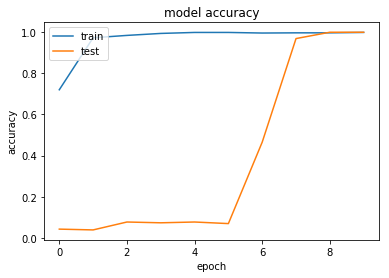

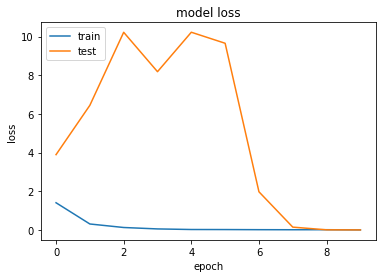

In [16]:
import matplotlib.pyplot as plt

fig = plt.figure()
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
fig.savefig('plot1.png')

# summarize history for loss
fig1 = plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
fig1.savefig('plot2.png')

### Test the Model

In [12]:
# get index of predicted dog Iris for each image in test set
iris_predictions = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]

# report test accuracy
test_accuracy = 100*np.sum(np.array(iris_predictions)==np.argmax(test_targets, axis=1))/len(iris_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 100.0000%


## Step 5: Blurring Task

**In the following code cell we add a bluring effect to the testing data to show the strength of our proposed approach**

The strength here is that the iris recognition is based on the area of iris that distinguish between persons. If this area is affected by blurring the area of irises my be overlapped. By the way, SVM could be used to classify images, but in this case the probability of error will be very high. Back to our project, In the this section we will evaluate the accuracy in the case of  blurring effect.

**Note:** We used the following cell one time to construct the blurring dataset

In [13]:
from PIL import Image
import cv2


#for i in range(len(test_files)):
#    img=cv2.imread(test_files[i])
#    img=cv2.blur(img,(7,7))
#    img = Image.fromarray(img , 'RGB')
#    filename = "casia/test_blur/file_%i.png"%i
#    #cv2.imwrite(filename, img)
#    img.save(filename)
test_blur_files, test_blur_targets = load_dataset('casia/test_blur')

                          

In [14]:


test_blur_tensors = paths_to_tensor(test_blur_files).astype('float32')/255

100%|████████████████████████████████████████████████████████████████████████████████| 260/260 [00:02<00:00, 93.25it/s]


### Test the Model in with the blurring effect

In [15]:
# get index of predicted Iris for each blured image in test set
iris_predictions2 = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_blur_tensors]

# report test accuracy
test_accuracy = 100*np.sum(np.array(iris_predictions)==np.argmax(test_targets, axis=1))/len(iris_predictions2)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 100.0000%


## Conclusion

**From results:**
 A
* **Our approach is better than the benchmark model as our approach acheived 100 % accuracy and the benchmark about 19 %.

* Another point of strength is effeciency under blurring as the proposed model still acheive 100 % accurracy that means it has noise immunity.